### Importing Libraries

In [0]:
import json
import tensorflow as tf
import csv
import random
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import pandas as pd

### Defining global variables

In [ ]:
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=1599999  #dataset size
test_portion=.1

corpus = []

### Downloading the data

In [46]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv \
    -O /tmp/training_cleaned.csv

--2020-06-03 00:14:46--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 2404:6800:4003:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘/tmp/training_cleaned.csv’

/tmp/training_clean 100%[===================>] 227.87M  68.7MB/s    in 3.3s    

2020-06-03 00:14:50 (68.7 MB/s) - ‘/tmp/training_cleaned.csv’ saved [238942690/238942690]



### Transforming the original data for Modeling

In [0]:
df=pd.read_csv('/tmp/training_cleaned.csv')

In [49]:
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [0]:
df.rename(columns={"0":"labels","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D":"sentences"},inplace=True)

In [0]:
df['labels']=np.where(df.labels!=0,1,0)

In [0]:
df['sentence_labels']=df['sentences'].str.cat(df['labels'].astype(str),sep=",")

In [53]:
df.head()

,labels,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,sentences,sentence_labels
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,"my whole body feels itchy and like its on fire ,0"
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....","@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew,"@Kwesidei not the whole crew ,0"


In [0]:
corpus=df['sentence_labels'].to_list()

In [55]:
print(len(corpus))
print(corpus[0])


1599999
is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!,0


### Tokenizing the words, creating text sequences and adding padding to the sentences to have input of equal lenghts

In [0]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][:-2])
    labels.append(int(corpus[x][-1]))


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
training_sequences = padded[split:training_size]
test_labels = np.array(labels[0:split])
training_labels = np.array(labels[split:training_size])

In [58]:
print(vocab_size)
print(word_index['i'])
# Expected Output
# 138858
# 1

690959
1


### # Using the 100 dimension version of GloVe from Stanford

In [59]:

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-06-03 00:16:20--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M   119MB/s    in 2.8s    

2020-06-03 00:16:23 (119 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [60]:
print(len(embeddings_matrix))

690960


### Creating Neural network with Embedding, LSTM and Dense Layers.

In [61]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           69096000  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 16, 128)           84480     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 69,230,145
Trainable params: 134,145
Non-trainable params: 69,096,000
_________________________________________________________________


In [62]:
num_epochs = 50
history = model.fit(training_sequences, training_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=2)

print("Training Complete")


Epoch 1/50
45000/45000 - 369s - loss: 0.4585 - accuracy: 0.7800 - val_loss: 0.4314 - val_accuracy: 0.7970
Epoch 2/50
45000/45000 - 364s - loss: 0.4189 - accuracy: 0.8046 - val_loss: 0.4178 - val_accuracy: 0.8057
Epoch 3/50
45000/45000 - 363s - loss: 0.4050 - accuracy: 0.8128 - val_loss: 0.4170 - val_accuracy: 0.8052
Epoch 4/50
45000/45000 - 363s - loss: 0.3959 - accuracy: 0.8178 - val_loss: 0.4148 - val_accuracy: 0.8075
Epoch 5/50
45000/45000 - 363s - loss: 0.3887 - accuracy: 0.8219 - val_loss: 0.4144 - val_accuracy: 0.8086
Epoch 6/50
45000/45000 - 363s - loss: 0.3827 - accuracy: 0.8252 - val_loss: 0.4179 - val_accuracy: 0.8062
Epoch 7/50
45000/45000 - 364s - loss: 0.3777 - accuracy: 0.8280 - val_loss: 0.4219 - val_accuracy: 0.8061
Epoch 8/50
45000/45000 - 364s - loss: 0.3735 - accuracy: 0.8299 - val_loss: 0.4205 - val_accuracy: 0.8065
Epoch 9/50
45000/45000 - 363s - loss: 0.3700 - accuracy: 0.8322 - val_loss: 0.4241 - val_accuracy: 0.8059
Epoch 10/50
45000/45000 - 362s - loss: 0.3666 

<Figure size 432x288 with 0 Axes>

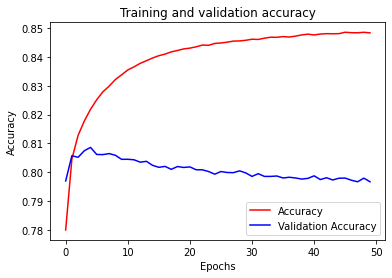

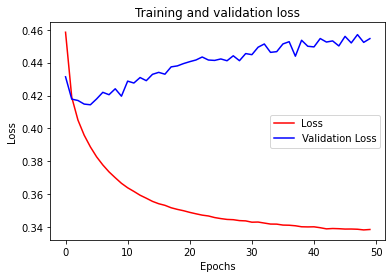

<Figure size 432x288 with 0 Axes>

In [63]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!